<a href="https://colab.research.google.com/github/bethuunltd/Weather-Prediction/blob/main/Seq2seq_ws.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

In [ ]:
df = pd.read_csv('data1.csv')
df.set_index('date',inplace=True)
df = df[["ws"]]
print(df.iloc[-72:])
wind = df["ws"].values


print(wind)

                       ws
date                     
2021-02-02 00:00:00  6.75
2021-02-02 01:00:00  6.99
2021-02-02 02:00:00  6.91
2021-02-02 03:00:00  6.49
2021-02-02 04:00:00  7.18
...                   ...
2021-02-04 19:00:00  3.17
2021-02-04 20:00:00  5.95
2021-02-04 21:00:00  7.17
2021-02-04 22:00:00  7.22
2021-02-04 23:00:00  7.07

[72 rows x 1 columns]
[ 8.27 10.91  8.59 ...  7.17  7.22  7.07]


In [ ]:
train_len = 0.7*len(wind)
val_len = 0.15*len(wind)

train_data = wind[:int(train_len)]
val_data = wind[int(train_len):int(train_len+val_len)]
test_data = wind[int(train_len+val_len):]

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data.reshape(-1,1)).flatten()
val_scaled = scaler.transform(val_data.reshape(-1,1)).flatten()
test_scaled = scaler.transform(test_data.reshape(-1,1)).flatten()#as all sklearn scalers need 2D input (N,)-->(N,1)

In [ ]:
class WeatherDataset(Dataset):
  def __init__(self,series,input_len=24,output_len=12):
    self.series = series
    self.input_len = input_len
    self.output_len = output_len
    self.total_len = input_len + output_len

  def __len__(self):
    return len(self.series)- self.total_len

  def __getitem__(self,i):
    full_seq = self.series[i:i+self.total_len]
    input_seq = full_seq[:self.input_len]
    output_seq = full_seq[self.input_len:]
    return (torch.tensor(input_seq).float().unsqueeze(-1), torch.tensor(output_seq).float().unsqueeze(-1))


In [ ]:
input_len = 12
output_len= 3
batch_size = 32


train_dataset = WeatherDataset(train_scaled,input_len,output_len)
val_dataset = WeatherDataset(val_scaled,input_len,output_len)
test_dataset = WeatherDataset(test_scaled,input_len,output_len)


train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,drop_last = True)
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False,drop_last = True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,drop_last = True)

In [ ]:
class Encoder(nn.Module):
  def __init__(self,input_dim,hidden_dim,num_layers=1):
    super().__init__()
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers
    self.input_dim = input_dim
    self.lstm = nn.LSTM(input_dim,hidden_dim,num_layers,batch_first=True)

  def forward(self,x):
    outputs,(h_n,c_n) = self.lstm(x)
    return h_n,c_n


class Decoder(nn.Module):
  def __init__(self,output_dim,hidden_dim,num_layers=1):#Change the number of layers later on to show what effects it will have on the model
    super().__init__()
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers
    self.output_dim = output_dim
    self.lstm = nn.LSTM(output_dim,hidden_dim,num_layers,batch_first=True)
    self.fc = nn.Linear(hidden_dim,output_dim)

  def forward(self,x,hidden,cell):
    outputs,(hidden,cell) = self.lstm(x,(hidden,cell))
    prediction = self.fc(outputs)
    return prediction, hidden, cell


class Seq2Seq(nn.Module):
  def __init__(self,encoder,decoder,device):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.device = device

  def forward(self,src,target_len,target_seq = None,teacher_forcing_ratio = 0.5):
    batch_size, seq_len, _ = src.size()
    outputs = []

    hidden,cell = self.encoder(src)
    input_decoder = src[:,-1:,:] #The last know value of windspeed(at hour 24) - Becomes the input for the decoder




    for t in range(target_len):
      output,hidden,cell = self.decoder(input_decoder,hidden,cell)
      outputs.append(output)


      if target_seq is not None and torch.rand(1).item () < teacher_forcing_ratio:
        input_decoder = target_seq[:,t:t+1,:] #This is the ground truth input
      else:
        input_decoder = output

    return torch.cat(outputs,dim=1) #Final shape: (batch_size, target_len, output_dim)











In [ ]:
# Model hyperparameters
input_dim = 1        # For univariate time series like windspeed
output_dim = 1
hidden_dim = 64
num_layers = 2       # You can increase this for deeper LSTM stacks
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate encoder and decoder
encoder = Encoder(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers)
decoder = Decoder(output_dim=output_dim, hidden_dim=hidden_dim, num_layers=num_layers)

# Wrap in Seq2Seq model
model = Seq2Seq(encoder=encoder, decoder=decoder, device=device).to(device)


In [ ]:
num_epochs = 40
teacher_forcing_ratio = 0.5
clip_grad_norm = 1


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.005)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


best_val_loss = np.inf
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)





/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for batch_idx, (src, target) in enumerate(train_loader):
        src = src.to(device)           # [batch_size, input_len, 1]
        target = target.to(device)     # [batch_size, target_len, 1]

        optimizer.zero_grad()

        output = model(
            src,
            target_len=target.size(1),
            target_seq=target,
            teacher_forcing_ratio=teacher_forcing_ratio
        )  # output: [batch_size, target_len, 1]

        loss = criterion(output, target)
        loss.backward()

        # Optional: Clip exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)

        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}")

    # Optional validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for src_val, target_val in val_loader:
            src_val = src_val.to(device)
            target_val = target_val.to(device)

            output_val = model(src_val, target_len=target_val.size(1), target_seq=None, teacher_forcing_ratio=0.0)
            val_loss += criterion(output_val, target_val).item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss:.4f}")

    scheduler.step(avg_loss)

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_seq2seq_model.pt')
        print("✅ Saved new best model!")


Epoch [1/40] - Loss: 0.0046
Validation Loss: 0.0042
✅ Saved new best model!
Epoch [2/40] - Loss: 0.0027
Validation Loss: 0.0039
✅ Saved new best model!
Epoch [3/40] - Loss: 0.0027
Validation Loss: 0.0040
Epoch [4/40] - Loss: 0.0026
Validation Loss: 0.0053
Epoch [5/40] - Loss: 0.0026
Validation Loss: 0.0050
Epoch [6/40] - Loss: 0.0026
Validation Loss: 0.0040
Epoch [7/40] - Loss: 0.0025
Validation Loss: 0.0045
Epoch [8/40] - Loss: 0.0026
Validation Loss: 0.0040
Epoch [9/40] - Loss: 0.0025
Validation Loss: 0.0037
✅ Saved new best model!
Epoch [10/40] - Loss: 0.0026
Validation Loss: 0.0040
Epoch [11/40] - Loss: 0.0025
Validation Loss: 0.0038
Epoch [12/40] - Loss: 0.0025
Validation Loss: 0.0036
✅ Saved new best model!
Epoch [13/40] - Loss: 0.0025
Validation Loss: 0.0043
Epoch [14/40] - Loss: 0.0025
Validation Loss: 0.0036
✅ Saved new best model!
Epoch [15/40] - Loss: 0.0024
Validation Loss: 0.0043
Epoch [16/40] - Loss: 0.0025
Validation Loss: 0.0037
Epoch [17/40] - Loss: 0.0025
Validation L

/tmp/ipython-input-10-3004925246.py:42: UserWarning: Glyph 127788 (\N{WIND BLOWING FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127788 (\N{WIND BLOWING FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


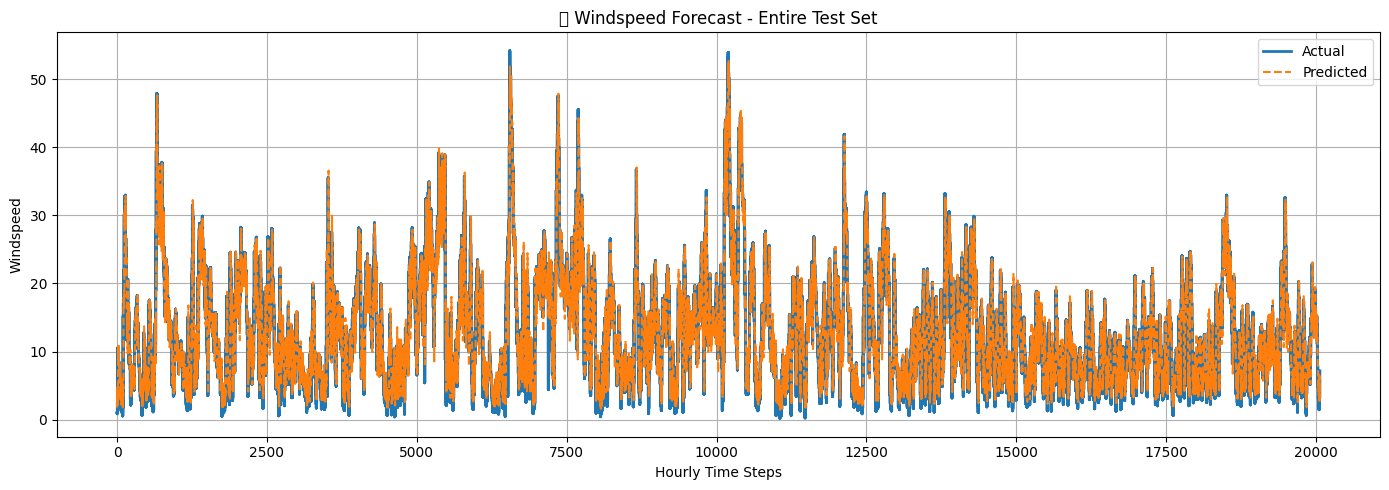

In [ ]:
# 📦 Load best model
model.load_state_dict(torch.load('best_seq2seq_model.pt', map_location=torch.device('cpu')))
device = torch.device('cpu')
model.to(device)
model.eval()
# 🔍 Run model over entire test set
all_preds = []
all_trues = []

with torch.no_grad():
    for src_batch, target_batch in test_loader:
        src_batch = src_batch.to(device)
        target_batch = target_batch.to(device)

        output_batch = model(
            src_batch,
            target_len=target_batch.size(1),
            target_seq=None,
            teacher_forcing_ratio=0.0
        )

        all_preds.append(output_batch.cpu())
        all_trues.append(target_batch.cpu())

# 🧱 Stack and reshape to (N, 1)
pred_full = torch.cat(all_preds, dim=0).reshape(-1, 1).numpy()
true_full = torch.cat(all_trues, dim=0).reshape(-1, 1).numpy()

# 🔄 Inverse transform
pred_inv = scaler.inverse_transform(pred_full)
true_inv = scaler.inverse_transform(true_full)

# 📊 Plot continuous predictions vs actuals
plt.figure(figsize=(14, 5))
plt.plot(true_inv, label='Actual', linewidth=2)
plt.plot(pred_inv, label='Predicted', linestyle='--')
plt.title("🌬️ Windspeed Forecast - Entire Test Set")
plt.xlabel("Hourly Time Steps")
plt.ylabel("Windspeed")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


✅ RMSE: 3.6178
✅ R² Score: 0.8140


/tmp/ipython-input-12-3925335854.py:50: UserWarning: Glyph 127788 (\N{WIND BLOWING FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-12-3925335854.py:51: UserWarning: Glyph 127788 (\N{WIND BLOWING FACE}) missing from font(s) DejaVu Sans.
  plt.savefig("wind_seq2seq.png",dpi=600)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127788 (\N{WIND BLOWING FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


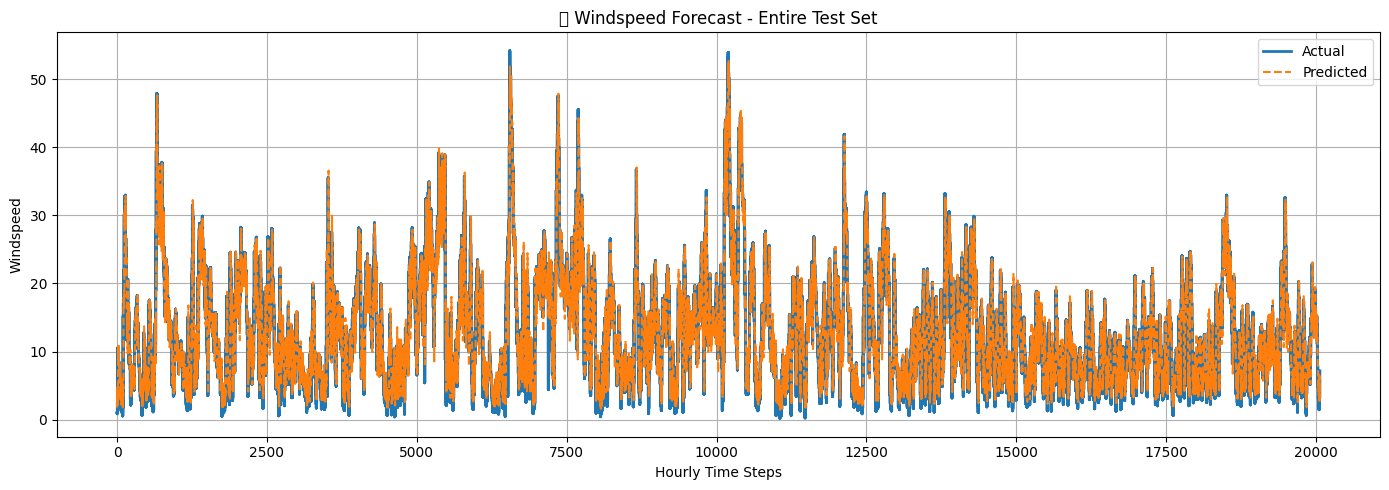

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
# 📦 Load best model
model.load_state_dict(torch.load('best_seq2seq_model.pt', map_location=torch.device('cpu')))
device = torch.device('cpu')
model.to(device)
model.eval()
# 🔍 Run model over entire test set
all_preds = []
all_trues = []


with torch.no_grad():
    for src_batch, target_batch in test_loader:
        src_batch = src_batch.to(device)
        target_batch = target_batch.to(device)

        output_batch = model(
            src_batch,
            target_len=target_batch.size(1),
            target_seq=None,
            teacher_forcing_ratio=0.0
        )

        all_preds.append(output_batch.cpu())
        all_trues.append(target_batch.cpu())

# 🧱 Stack and reshape to (N, 1)
pred_full = torch.cat(all_preds, dim=0).reshape(-1, 1).numpy()
true_full = torch.cat(all_trues, dim=0).reshape(-1, 1).numpy()

# 🔄 Inverse scaling
pred_inv = scaler.inverse_transform(pred_full)
true_inv = scaler.inverse_transform(true_full)

# 📉 Evaluation metrics
rmse = mean_squared_error(true_inv, pred_inv) ** 0.5
r2 = r2_score(true_inv, pred_inv)
print(f"✅ RMSE: {rmse:.4f}")
print(f"✅ R² Score: {r2:.4f}")

# 📊 Plot
plt.figure(figsize=(14, 5))
plt.plot(true_inv, label='Actual', linewidth=2)
plt.plot(pred_inv, label='Predicted', linestyle='--')
plt.title("🌬️ Windspeed Forecast - Entire Test Set")
plt.xlabel("Hourly Time Steps")
plt.ylabel("Windspeed")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("wind_seq2seq.png",dpi=600)
plt.show()


/tmp/ipython-input-13-1352410321.py:47: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


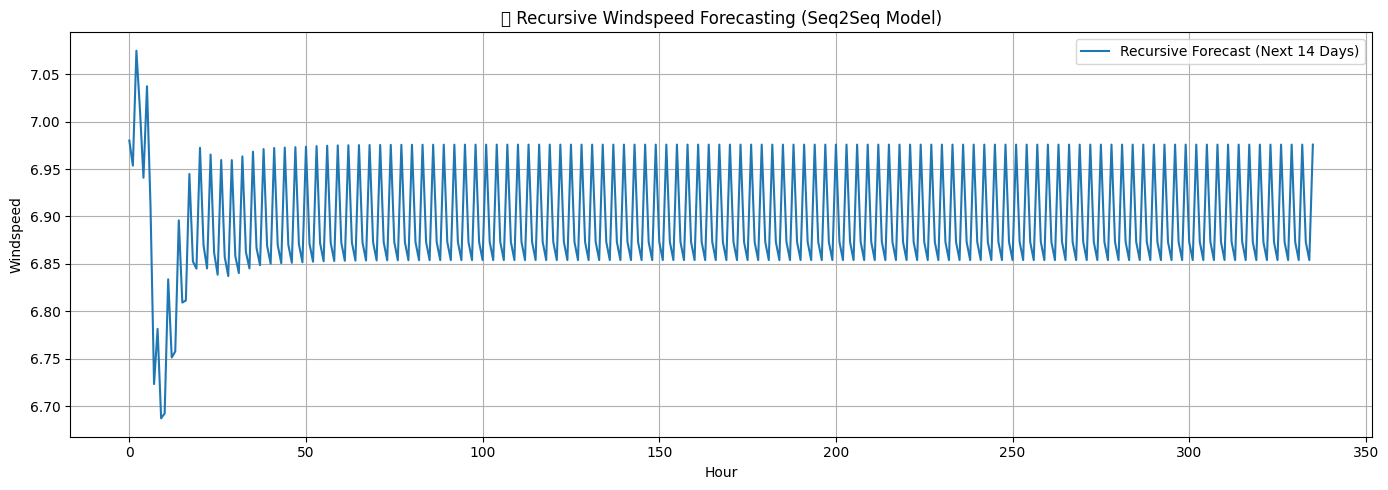

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Forecast horizon: 14 days × 24 hours
forecast_horizon = 336  # hours
input_window = input_len  # e.g., 12
step_size = output_len    # e.g., 3

# Start from last known input in test set
initial_input = torch.tensor(test_scaled[-input_window:]).float().unsqueeze(0).unsqueeze(-1).to(device)

model.eval()
predictions = []

with torch.no_grad():
    current_input = initial_input.clone()

    while len(predictions) * step_size < forecast_horizon:
        output = model(
            current_input,
            target_len=step_size,
            target_seq=None,
            teacher_forcing_ratio=0.0
        )  # output shape: [1, step_size, 1]

        predictions.append(output.squeeze().cpu().numpy())

        # Prepare next input window: concatenate new prediction with previous input
        new_input = torch.cat([current_input.squeeze(0), output.squeeze(0)], dim=0)[-input_window:]
        current_input = new_input.unsqueeze(0)

# Stack and slice exactly 336 steps
pred_recursive = np.concatenate(predictions)[:forecast_horizon].reshape(-1, 1)

# Inverse scale to real windspeed
pred_recursive_inv = scaler.inverse_transform(pred_recursive)

# Plot recursive forecast
plt.figure(figsize=(14, 5))
plt.plot(pred_recursive_inv, label='Recursive Forecast (Next 14 Days)', color='tab:blue')
plt.title("🔁 Recursive Windspeed Forecasting (Seq2Seq Model)")
plt.xlabel("Hour")
plt.ylabel("Windspeed")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
